# Preprocessing of dMRI data

This preprocessing is based on Wiktor's work with dMRI data. A specific file is taken as an example.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import nibabel as nib
from os import listdir
from os.path import isfile, join
from scipy import signal
import lib

In [3]:
# current path
cur_path = os.getcwd()
# file name and path
file = "BB_003_3T_cmrr_mbep2d_diff_0pt2_1_task_18s_off_12s_on_20200710180104_8"
file_name = cur_path + "/" + str(file) + "/dfMRI_raw.nii.gz"
# loading nifti object/header
raw_data_ = nib.load(file_name)
header  = raw_data_.header
raw_data = raw_data_.get_fdata()

In [8]:
header.get_xyzt_units(), raw_data.shape

(('mm', 'sec'), (116, 116, 14, 600))

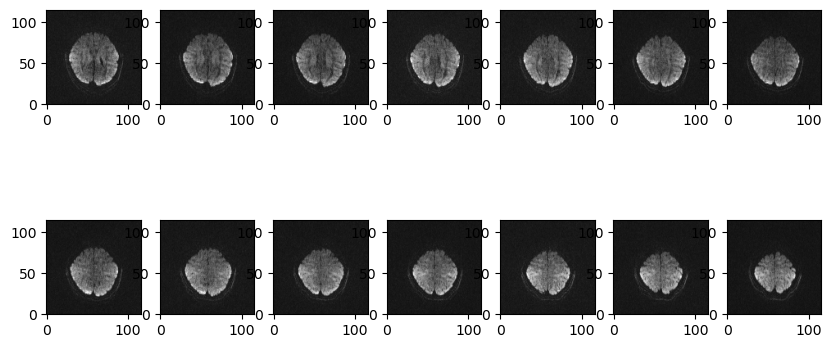

In [4]:
def print_volume(data, time=15):
    # print all slices wrt z axis after defining a random time 
                
    nrows = 2
    ncols = int(data.shape[2]/nrows)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(10, 5))

    for i in range(data.shape[2]):
        if data.ndim == 4:
            slice = data[:, :, i,time]
        elif data.ndim == 3:
            slice = data[...,i]
        ax[i//ncols][i%ncols].imshow(slice.T, cmap="gray", origin="lower")

print_volume(raw_data)

# Getting rid of the first volumes

1st volume for some scans has to be removed as sometimes it has another b-value than the remaining volumes (we wanted to cover different b-values - calibration issues)


In [110]:
No_dummies_out = 2
dfMRI_raw  = raw_data[:,:,:,No_dummies_out:]
No_volumes = raw_data.shape[3] - No_dummies_out
dfMRI_raw.shape, No_volumes

((116, 116, 14, 598), 598)

# Identifying volume outliers and removing them

In [99]:
if "diff" in file_name:
    # if it is diffusion data
    make_adc = True
else :
    # BOLD 
    make_adc = False

In [100]:
# compress into 2D
dfMRI_raw_2D = dfMRI_raw.reshape(dfMRI_raw.shape[0]*dfMRI_raw.shape[1]*dfMRI_raw.shape[2], dfMRI_raw.shape[3])

In [101]:
dfMRI_raw_2D.shape

(188384, 598)

In [102]:
# mean over the volume
mean_dfMRI_raw_2D = np.mean(dfMRI_raw_2D, axis = 0)

In [103]:
mean_dfMRI_raw_2D.shape

(598,)

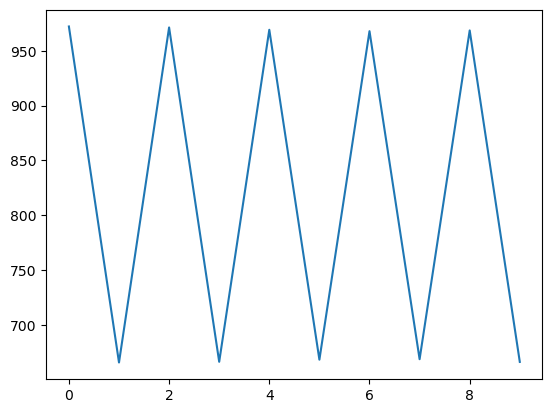

In [104]:
plt.plot(mean_dfMRI_raw_2D[:10])

This shows that there are 2 different b values in the data that need to be separated

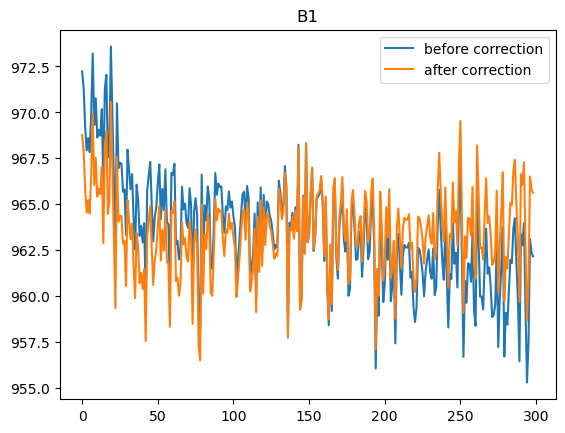

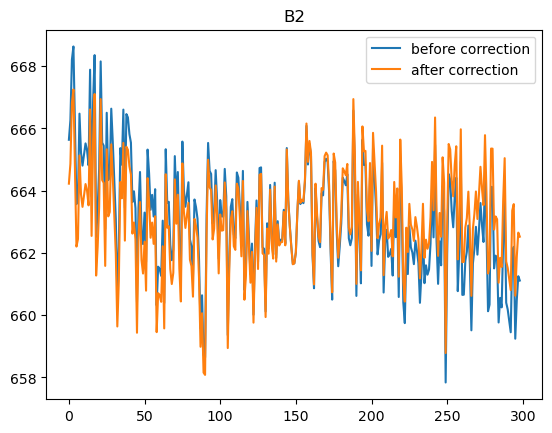

In [105]:
# acquisition scheme : b1-b2-b1-b2-b1-.... 
# => 2 series of b values
nb_series = 2
vol_outliers_thr = 0.01

if make_adc:

    for i in range(nb_series):
        # separate b values according to their index
        b_idx = np.arange(i, len(mean_dfMRI_raw_2D), 2)
        b_mean_dfMRI = mean_dfMRI_raw_2D[b_idx]
        length_b = len(b_mean_dfMRI)
        b_dfMRI_raw = dfMRI_raw[...,b_idx]
    
        # detrend for movement correction
        b_mean_dfMRI_det = signal.detrend(b_mean_dfMRI) - np.mean(signal.detrend(b_mean_dfMRI)) \
                           + np.mean(b_mean_dfMRI)

        plt.figure()
        plt.plot(b_mean_dfMRI, label = "before correction")
        plt.plot(b_mean_dfMRI_det, label = "after correction")
        plt.title(f"B{i+1}")
        plt.legend()

        # Find outliers (if any)
        b_mean_dfMRI_outliers = b_mean_dfMRI_det.copy()
        med = np.median(b_mean_dfMRI_outliers)
        b_idx_outliers = np.where(abs(b_mean_dfMRI_outliers- med) > vol_outliers_thr*med)

        # Remove the outliers (if any)
        if b_idx_outliers:
            b_mean_dfMRI_det[b_idx_outliers] = np.nan
            b_idx_non_outliers = np.setdiff1d(np.linspace(0, length_b-1, length_b), b_idx_outliers).astype(int)

        # Interpolation doesn't work for 1st and last elements - they cannot be Nan
        b_mean_dfMRI_det[0] = b_mean_dfMRI_det[b_idx_non_outliers[0]]
        b_mean_dfMRI_det[-1] = b_mean_dfMRI_det[b_idx_non_outliers[-1]]
        b_dfMRI_raw[...,0] = b_dfMRI_raw[..., b_idx_non_outliers[0]]
        b_dfMRI_raw[...,-1] = b_dfMRI_raw[..., b_idx_non_outliers[-1]]

        # If the first non-outliers idx is not 0, then add 0
        # Indeed, volume 0 cannot be interpolated with surrounding volumes
        if b_idx_non_outliers[0] > 0 : b_idx_non_outliers = [0, b_idx_non_outliers]
        # Same logic but for last volume
        if b_idx_non_outliers[-1] < length_b : b_idx_non_outliers = [b_idx_non_outliers, length_b-1]

        # If the mean of a volume is 0, then find the first non outliers id before and after 
        # the current volume_id and replace it by the avg of id_before and id_after
        for volume_idx in range(1, length_b):
            if b_mean_dfMRI_det[volume_idx] == 0:
                # Idx before volume_idx that contains a non-outliers
                idx_before = max(b_idx_non_outliers[b_idx_non_outliers < volume_idx])
                # Idx after volume_idx that contains a non-outliers
                idx_after = max(b_idx_non_outliers[b_idx_non_outliers > volume_idx])
                b_mean_dfMRI_det[volume_idx] = (b_mean_dfMRI_det[idx_before]+b_mean_dfMRI_det[idx_after])/2
                b_dfMRI_raw[...,volume_idx] = (b_dfMRI_raw[...,idx_before]+b_dfMRI_raw[...,idx_after])/2

        # Put the corrected value in the raw volume (with all b)
        mean_dfMRI_raw_2D[b_idx] = b_mean_dfMRI_det
        dfMRI_raw[...,b_idx] = b_dfMRI_raw

        

In [106]:
del b_mean_dfMRI_outliers, b_idx_non_outliers, b_idx_outliers, mean_dfMRI_raw_2D

In [107]:
img = nib.Nifti1Image(dfMRI_raw, np.eye(4))

In [108]:
dfMRI_raw.shape

(116, 116, 14, 598)

In [109]:
nib.save(img, 'test_part1.nii.gz')  

# PCA denoising

Open terminal in the right folder and run :

dwidenoise test_part1.nii.gz test_part2.nii.gz -noise noise.nii.gz -extent 9 -force

In [5]:
file_name = cur_path + "/data/test_part2.nii.gz"
# loading nifti object
pca_dfmri = nib.load(file_name)
pca_dfmri = pca_dfmri.get_fdata()


In [6]:
file_name = cur_path + "/data/noise.nii.gz"
# loading nifti object
noise = nib.load(file_name)
noise = noise.get_fdata()

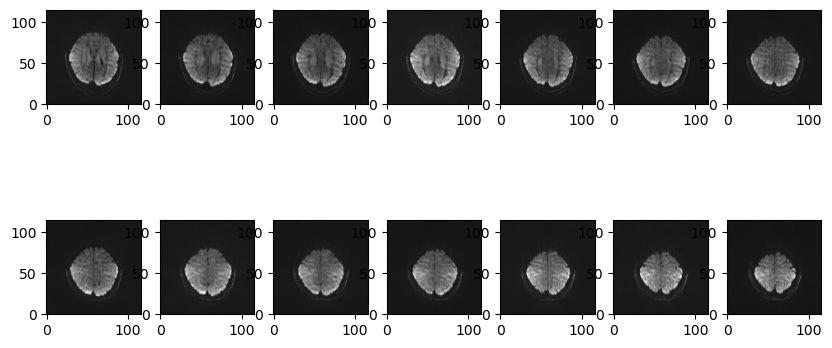

In [7]:
print_volume(pca_dfmri)

In [8]:
noise.shape

(116, 116, 14)

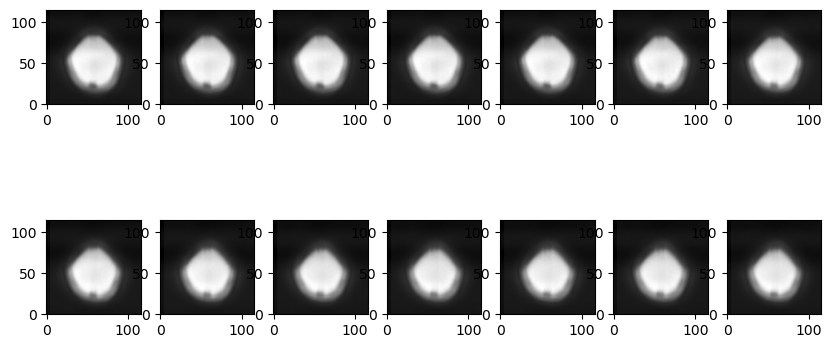

In [9]:
print_volume(noise)

Option 1 :

Run in terminal : mrdegibbs test_part2.nii.gz test_mrdegibbs.nii.gz

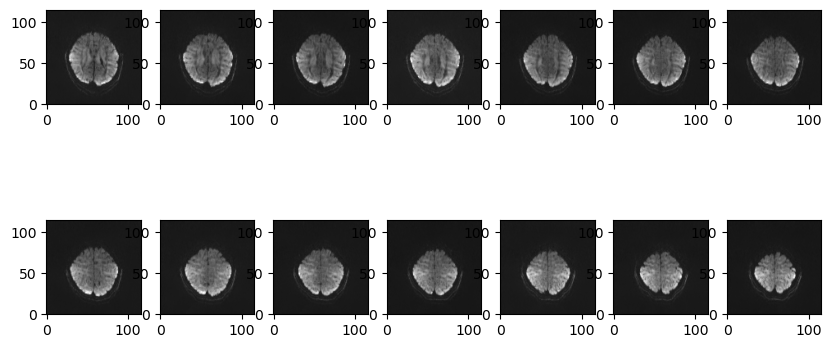

In [10]:
file_name = cur_path + "/data/test_mrdegibbs.nii.gz"
# loading nifti object
mrdegibbs_dfmri = nib.load(file_name)
mrdegibbs_dfmri = mrdegibbs_dfmri.get_fdata()

print_volume(mrdegibbs_dfmri)

Option 2 :

In [11]:
def flushprint(text):
    sys.stdout.write(f'{text} \r')
    sys.stdout.flush()

In [12]:
def cpheader(from_im, to_im, newimg=False, cpbytes=False):
    """Copy the header by replacing the data of to_im to from_im.
        By default, tries overwrites to_im, newimg='path' to save a new img"""
    # ToDo: test copy bytes
    if not cpbytes:
        to_im_name = to_im
        from_im = nib.load(from_im)
        to_im = nib.load(to_im)
        new_img = to_im.__class__(to_im.dataobj[:], from_im.affine, from_im.header)
        if newimg:
            new_img.to_filename(newimg)
        else:
            out = to_im_name
            os.rename(out, out.replace('.nii', '__TMP4HDRCOPY__.nii'))
            new_img.to_filename(out)
            os.remove(out.replace('.nii', '__TMP4HDRCOPY__.nii'))
    else:
        with open(from_im, "rb") as donor:
            if newimg:
                with open(newimg, "wb") as receiver:
                    receiver.seek(0)  # set bytes offset at 0
                    receiver.write(donor.read()[0:349])  # First 348 bytes are the header
                    receiver.seek(349)  # set bytes offset at 349
                    with open(to_im, "rb") as datadonor:
                        receiver.write(datadonor.read()[349:])  # write data from the 349 byte
            else:
                with open(to_im, "wb") as receiver:
                    receiver.seek(0)  # set bytes offset at 0
                    receiver.write(donor.read()[0:349])  # First 348 bytes are the header


In [13]:
def split_degibbs(denoisedimage, dictlist, MATLABEXEC='', newimg='/split_degibbs_dwi.nii.gz', dim=2,
                  partialfourier=0.75, software='reisert', delete_subparts=True):
    # Split the denoised image into 5
    start = time.time()
    img = nib.load(denoisedimage)
    # Initialize the list
    split_degibbs_dictlist = []
    start_bid = 0
    for img_nb in range(len(dictlist)):
        # Split the dwi nifti from files_dic according to the length of the 'img_nb'th bval vector
        bval_length = len(np.loadtxt(dictlist[img_nb]['bval'], dtype=int))
        newnifti = nib.Nifti1Image(img.get_fdata()[..., start_bid:(start_bid + bval_length)], affine=img.affine,
                                   header=img.header)
        nib.save(newnifti, denoisedimage.replace('.nii.gz', f'_subpart-{img_nb}.nii.gz'))
        start_bid += bval_length
        # Create a new dictionary for the splitted part
        # Copy the content of bvals, bvec and json from each dictionary in diclist
        files_dic_spec = dictlist[img_nb].copy()
        files_dic_spec['dwi'] = denoisedimage.replace('.nii.gz', f'_subpart-{img_nb}.nii.gz')
        # Apply degibbs on each splitted part
        split_degibbs_dic = degibbs(files_dic_spec, MATLABEXEC=MATLABEXEC,
                                    newimg=newimg.replace('.nii.gz', f'_subpart-{img_nb}.nii.gz'),
                                    dim=dim, partialfourier=partialfourier, software=software)
        # Append the result to the list of processed parts
        split_degibbs_dictlist.append(split_degibbs_dic)
        # Remove the denoised subpart
        if delete_subparts:
            os.remove(denoisedimage.replace('.nii.gz', f'_subpart-{img_nb}.nii.gz'))
    # Merge results
    file = merge_degibbs(split_degibbs_dictlist, newimage=newimg, delete_subparts=delete_subparts)

    print("Split, degibbs & merge finished !")
    end = time.time()
    print(f"In :{int((end - start) // 3600)}h, {int((end - start) % 3600 // 60)}min and {int((end - start) % 60)}s.")

    return file


def merge_degibbs(files, newimage='/split_degibbs_dwi.nii.gz', delete_subparts=True):
    baseimg = nib.load(files)
    aff, hdr = baseimg.affine, baseimg.header
    basedata = baseimg.get_fdata()
    # Remove old subpart file
    if delete_subparts:
        os.remove(files[0])

    for id, dic in enumerate(dictlist[1:], 1):
        # Merge dwi 4th dim (axis = 3)
        basedata = np.concatenate([basedata, nib.load(dic['dwi']).get_fdata()], axis=3)

        # Remove old subpart file
        if delete_subparts:
            os.remove(dictlist[id]['dwi'])

    files_dic = {'bval': newimage.replace('_desc-splitted_degibbs_dwi.nii.gz', '_dwi.bval'),
                 'bvec': newimage.replace('_desc-splitted_degibbs_dwi.nii.gz', '_dwi.bvec'),
                 'json': [d['json'] for d in dictlist],
                 'dwi': newimage,
                 'tdval': newimage.replace('_desc-splitted_degibbs_dwi.nii.gz', '_dwi.tdval')}

    newimg = nib.Nifti1Image(basedata, affine=aff, header=hdr)
    nib.save(newimg, newimage)


In [25]:
# step 3 : de-Gibbs ringing functions
# thanks to Quentin and Tommaso !
def degibbs(in_dwi, newimg='test_part3.nii.gz', software='reisert', dim=3, partialfourier=0.75, MATLABEXEC=''):
    """
    :param files_dic: dictionary of current file to be processed
    :param newimg: output file name
    :param dim: dim
    :param partialfourier: partial fourier values
    :param MATLABEXEC: matlab executable path
    :return: files dictionary with updated degibbs file
    """

    origin = os.getcwd()  # get .py file position in the pc

    if software == 'rpg':
        in_dwi_nii = gzip(in_dwi, gz=False)
        print(f'Running rpg degibbs in: {origin}')
        a = '"'  # apostrophe
        command = [f"{MATLABEXEC}",
                   f"-sd {os.getcwd()} -batch {a}",
                   f"addpath(genpath('{origin}/lib/rpgdegibbs/lib'));"
                   f"addpath(genpath('{origin}/lib/NIFTI'));"
                   f"root='{os.path.dirname(in_dwi_nii)}';"
                   f"warning('off','all');"
                   f"rpg = rpgdegibbs();"
                   f"P_pf = load_untouch_nii('{in_dwi_nii}');"
                   f"dim = {dim};"
                   f"pf = {partialfourier};"
                   f"P_pf_dg = rpg.degibbs(abs(double(P_pf.img)), dim, pf);"
                   f"P_pf.img = P_pf_dg;"
                   f"disp('Gibbs unringing');"
                   f"save_untouch_nii(P_pf, '{newimg.replace('.gz', '')}');"
                   f"quit force;"
                   f"{a}"]
        sp.run(command)
        newimage = gzip(newimg.replace('.gz', ''), gz=True)

    elif software == 'reisert':
        # from:  https://bitbucket.org/reisert/unring/src/master/matlab/unring.m
        print(f'Running reisert unring in: {origin}')
        dwi = nib.load(in_dwi)
        tmp_names = list()

        for v in range(dwi.shape[-1]):
            flushprint(f'{100 / dwi.shape[-1] * v}')
            newnifti = nib.Nifti1Image(dwi.get_fdata()[:,:, :, v], affine=dwi.affine, header=dwi.header)
            tmpname = newimg.replace('.nii.gz', f'_TMP{v}.nii.gz')
            nib.save(newnifti, tmpname)
            os.system(
                f'{origin}/lib/reisert_unring/fsl/unring.a64 {tmpname} {tmpname} -d {dim} >> {newimg.replace(".nii.gz", ".unring.log")}')
            os.remove(newimg.replace(".nii.gz", ".unring.log"))
            tmp_names.append(tmpname)
  

        os.system(f'fslmerge -t {newimg} {" ".join(tmp_names)}')
        cpheader(in_dwi, newimg)
        if os.path.isfile(newimg):
            [os.remove(tmp) for tmp in tmp_names]
    else:
        raise ValueError("software could be only 'reisert'(c) or 'rpg'(matlab) ")

    if not os.path.isfile(newimg):
        raise ValueError('Degibbs Failed!')

In [26]:
degibbs(cur_path + "/data/test_part2.nii.gz", newimg=cur_path + "/data/test_reisert.nii.gz")

Running reisert unring in: /home/localadmin/Documents/preprocessing


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.
.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.


.
.


In [22]:
degibbs(cur_path + "/data/test_part2.nii.gz", newimg=cur_path + "/data/test_rpg.nii.gz", software='rpg')

TypeError: 'module' object is not callable